In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_RAW, DATA_PROCESSED

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set_theme(style="whitegrid", palette="muted")

print("✅ Imports OK")

✅ Imports OK


In [ ]:
parquet_path = DATA_RAW / "secop_raw.parquet"df = pd.read_parquet(parquet_path)# Validate data quality: no duplicates allowedduplicates = len(df) - df["id_contrato"].nunique()assert df["id_contrato"].is_unique, f"❌ Duplicates found: {duplicates:,}"print(f"Shape:    {df.shape[0]:,} rows × {df.shape[1]} columns")print(f"Memory:   {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")print(f"\nDate range:")print(f"  Earliest: {df['fecha_de_inicio_del_contrato'].min()}")print(f"  Latest:   {df['fecha_de_inicio_del_contrato'].max()}")

Shape:    1,500,000 rows × 28 columns
Memory:   3039.7 MB

Date range:
  Earliest: 2019-01-01 00:00:00
  Latest:   2022-08-06 00:00:00


In [ ]:
null_rates = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
null_rates = null_rates[null_rates > 0]

print("Columns with nulls:\n")
for col, rate in null_rates.items():
    print(f"  {col:<45} {rate:.1f}%")

Columns with nulls:

  fecha_de_firma                                0.8%
  fecha_de_fin_del_contrato                     0.0%


Contract Value Summary (COP):
  Zero values:     0
  Negative values: 0
  Min:             1
  Median:          22,000,000
  Mean:            232,624,846
  Max:             9,974,265,138,436
  >1B COP:         27,086 contracts
  <10K COP:        477 contracts


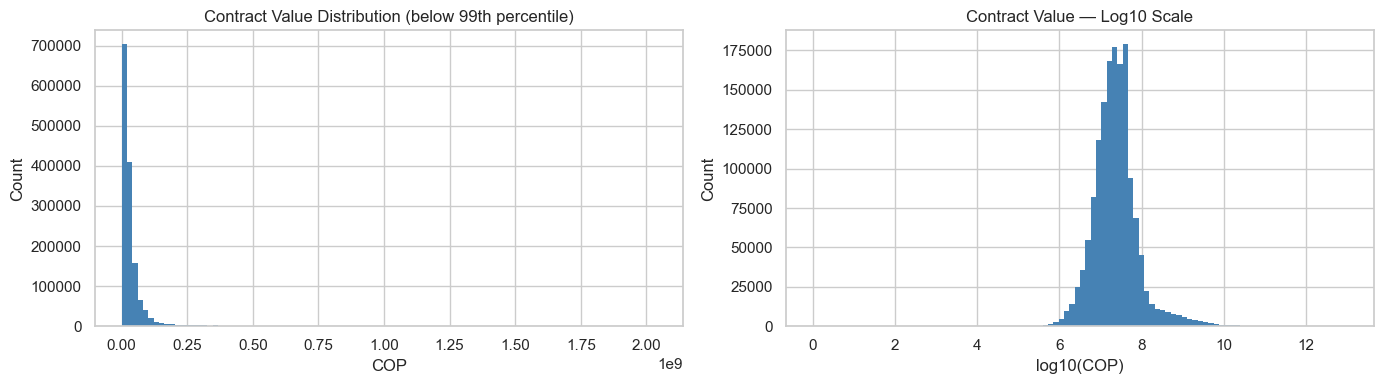

✅ Saved chart


In [ ]:
v = df["valor_del_contrato"]

print("Contract Value Summary (COP):")
print(f"  Zero values:     {(v == 0).sum():,}")
print(f"  Negative values: {(v < 0).sum():,}")
print(f"  Min:             {v.min():,.0f}")
print(f"  Median:          {v.median():,.0f}")
print(f"  Mean:            {v.mean():,.0f}")
print(f"  Max:             {v.max():,.0f}")
print(f"  >1B COP:         {(v > 1_000_000_000).sum():,} contracts")
print(f"  <10K COP:        {(v < 10_000).sum():,} contracts")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Raw distribution
axes[0].hist(v[v < v.quantile(0.99)], bins=100, color="steelblue", edgecolor="none")
axes[0].set_title("Contract Value Distribution (below 99th percentile)")
axes[0].set_xlabel("COP")
axes[0].set_ylabel("Count")

# Log distribution
log_v = np.log10(v[v > 0])
axes[1].hist(log_v, bins=100, color="steelblue", edgecolor="none")
axes[1].set_title("Contract Value — Log10 Scale")
axes[1].set_xlabel("log10(COP)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("../outputs/charts/01_contract_value_distribution.png", dpi=150)
plt.show()
print("✅ Saved chart")

In [ ]:
modality = df["modalidad_de_contratacion"].value_counts()
modality_pct = (modality / len(df) * 100).round(1)

print("Contracting Modality Breakdown:\n")
for name, count in modality.items():
    pct = modality_pct[name]
    bar = "█" * int(pct / 2)
    print(f"  {name:<45} {count:>8,}  ({pct:>5.1f}%)  {bar}")

# Direct award rate — your headline EDA finding
direct_keywords = ["directa", "régimen especial"]
is_direct = df["modalidad_de_contratacion"].str.lower().str.contains(
    "|".join(direct_keywords), na=False
)
print(f"\n⚠️  Direct/Non-competitive award rate: {is_direct.mean()*100:.1f}% of all contracts")
print(f"   This is your headline finding. Document it.")

Contracting Modality Breakdown:

  Contratación directa                          1,167,868  ( 77.9%)  ██████████████████████████████████████
  Contratación régimen especial                  153,644  ( 10.2%)  █████
  Mínima cuantía                                 102,004  (  6.8%)  ███
  Selección Abreviada de Menor Cuantía            18,600  (  1.2%)  
  Contratación Directa (con ofertas)              18,042  (  1.2%)  
  Selección abreviada subasta inversa             16,212  (  1.1%)  
  Contratación régimen especial (con ofertas)     11,036  (  0.7%)  
  Licitación pública                               4,601  (  0.3%)  
  Concurso de méritos abierto                      4,413  (  0.3%)  
  Licitación pública Obra Publica                  2,997  (  0.2%)  
  Seleccion Abreviada Menor Cuantia Sin Manifestacion Interes      443  (  0.0%)  
  Enajenación de bienes con sobre cerrado             70  (  0.0%)  
  Licitación Pública Acuerdo Marco de Precios         37  (  0.0%)  
  Enajena

In [ ]:
status = df["estado_contrato"].value_counts()
print("Contract Status:\n")
for name, count in status.items():
    pct = count / len(df) * 100
    print(f"  {name:<30} {count:>8,}  ({pct:.1f}%)")

# Modified contracts — second proxy signal
is_modified = df["estado_contrato"] == "Modificado"
print(f"\n  Modified contracts: {is_modified.sum():,} ({is_modified.mean()*100:.1f}%)")

Contract Status:

  Cerrado                         623,422  (41.6%)
  Modificado                      266,002  (17.7%)
  En ejecución                    261,782  (17.5%)
  terminado                       259,950  (17.3%)
  Aprobado                         69,112  (4.6%)
  cedido                            6,923  (0.5%)
  Borrador                          5,578  (0.4%)
  enviado Proveedor                 2,948  (0.2%)
  En aprobación                     1,834  (0.1%)
  Cancelado                         1,622  (0.1%)
  Suspendido                          827  (0.1%)

  Modified contracts: 266,002 (17.7%)


Year-over-Year Summary:

  Year      Contracts  Total Spend (B COP)    Median Value
  ---------------------------------------------------------
  2019      149,137.0              67725.0      27,825,000
  2020      354,381.0             102354.1      19,892,436
  2021      551,415.0             117121.0      20,000,000
  2022      445,067.0              61737.2      25,000,000


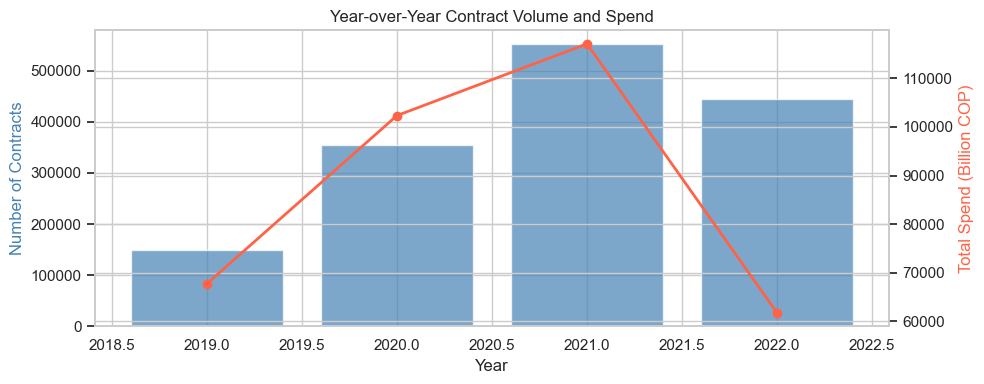

In [ ]:
df["year"] = df["fecha_de_inicio_del_contrato"].dt.year

yoy = df.groupby("year").agg(
    contracts=("id_contrato", "count"),
    total_spend=("valor_del_contrato", "sum"),
    median_value=("valor_del_contrato", "median")
).reset_index()

yoy["total_spend_B"] = yoy["total_spend"] / 1e9

print("Year-over-Year Summary:\n")
print(f"  {'Year':<6} {'Contracts':>12} {'Total Spend (B COP)':>20} {'Median Value':>15}")
print("  " + "-" * 57)
for _, row in yoy.iterrows():
    print(f"  {int(row.year):<6} {row.contracts:>12,} {row.total_spend_B:>20.1f} {row.median_value:>15,.0f}")

fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.bar(yoy["year"], yoy["contracts"], color="steelblue", alpha=0.7, label="Contracts")
ax2.plot(yoy["year"], yoy["total_spend_B"], color="tomato", marker="o", linewidth=2, label="Spend (B COP)")

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Contracts", color="steelblue")
ax2.set_ylabel("Total Spend (Billion COP)", color="tomato")
ax1.set_title("Year-over-Year Contract Volume and Spend")

plt.tight_layout()
plt.savefig("../outputs/charts/01_yoy_volume.png", dpi=150)
plt.show()

In [ ]:
print("Top 10 Sectors by contract count:\n")
print(df["sector"].value_counts().head(10).to_string())

print("\nTop 10 Departments by contract count:\n")
print(df["departamento"].value_counts().head(10).to_string())

Top 10 Sectors by contract count:

sector
Servicio Público                     336536
Salud y Protección Social            196503
No aplica/No pertenece               190780
Trabajo                              100835
defensa                               87323
Educación Nacional                    82754
Ambiente y Desarrollo Sostenible      69260
Inclusión Social y Reconciliación     67122
deportes                              48409
Cultura                               47229

Top 10 Departments by contract count:

departamento
Distrito Capital de Bogotá    641108
Valle del Cauca               158936
Antioquia                     111239
Santander                      61028
Atlántico                      47538
Cundinamarca                   43395
Tolima                         37538
Bolívar                        36979
Risaralda                      30129
Norte de Santander             28412


In [ ]:
print("=" * 55)
print("DATA QUALITY SUMMARY")
print("=" * 55)
print(f"Total contracts loaded:        {len(df):>10,}")
print(f"Date range:                    2019-01-01 → 2022-08-06")
print(f"Columns available:             {len(df.columns):>10}")
print(f"Columns with any nulls:        {(df.isnull().sum() > 0).sum():>10}")
print(f"Zero-value contracts:          {(df['valor_del_contrato'] == 0).sum():>10,}")
print(f"Direct/non-competitive awards: {is_direct.sum():>10,}  ({is_direct.mean()*100:.1f}%)")
print(f"Modified contracts:            {is_modified.sum():>10,}  ({is_modified.mean()*100:.1f}%)")
print("=" * 55)
print("\n✅ Data quality audit complete. Ready for EDA.")

DATA QUALITY SUMMARY
Total contracts loaded:         1,500,000
Date range:                    2019-01-01 → 2022-08-06
Columns available:                     29
Columns with any nulls:                 2
Zero-value contracts:                   0
Direct/non-competitive awards:  1,350,590  (90.0%)
Modified contracts:               266,002  (17.7%)

✅ Data quality audit complete. Ready for EDA.
